In [1]:
from rtergpy.run import defaults, event
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Defaults=defaults()
Event=event()
print(os.getcwd())
os.chdir('../Examples')

runs=pd.read_pickle('Results_2000-late2021.01.pkl')

/Users/anewman/Documents/Projects/rterg/processing/notebooks


In [60]:
mintime=0.5*60*60  # 30 min
runsclean=runs.copy()
drops=[]
keeps=[]
for i in range(len(runs)):
    if i >= 1:
        if runs.etime[i]-runs.etime[i-1]<mintime:
            #print(i)
            drops.append(i)
            print(i, runs.etime[i-1],runs.etime[i], runs.elat[i-1],runs.elon[i-1],runs.edepth[i-1], runs.elat[i],runs.elon[i],runs.edepth[i],runs.Mw[i-1],runs.Mw[i])
        else:
            keeps.append(i)

runsdirty=runsclean.drop(index=keeps)
runsclean.drop(index=drops, inplace=True)
runsclean=runsclean.reset_index()
len(drops)

83 2002-08-19T11:01:01.200000Z 2002-08-19T11:08:24.300000Z -21.74 -179.08 630.9 -24.16 178.49 699.3 7.62 7.68
240 2006-11-15T11:14:17.800000Z 2006-11-15T11:40:55.100000Z 46.71 154.33 13.5 46.47 154.83 23.3 8.29 6.68
242 2006-12-26T12:26:21.100000Z 2006-12-26T12:34:13.800000Z 21.81 120.52 19.6 22.02 120.4 32.8 6.98 6.9
251 2007-03-25T00:40:01.600000Z 2007-03-25T00:41:57.800000Z -20.6 169.12 41.2 37.28 136.61 12.0 7.13 6.67
252 2007-03-25T00:41:57.800000Z 2007-03-25T01:08:19.000000Z 37.28 136.61 12.0 -20.89 168.99 31.3 6.67 6.89
323 2008-09-11T00:00:02.700000Z 2008-09-11T00:20:50.900000Z 1.91 127.34 119.6 41.79 144.11 20.0 6.58 6.76
362 2009-10-07T21:41:13.300000Z 2009-10-07T22:03:14.500000Z 4.11 122.51 579.5 -12.59 166.27 44.2 6.76 7.61
363 2009-10-07T22:03:14.500000Z 2009-10-07T22:18:51.200000Z -12.59 166.27 44.2 -11.86 166.01 41.7 7.61 7.81
365 2009-10-07T22:50:15.800000Z 2009-10-07T23:13:48.200000Z -12.59 165.89 17.8 -13.12 166.37 42.5 6.8 7.41
387 2010-03-11T14:39:44.000000Z 2010-03

23

In [3]:
#251 2007-03-25T00:40:01.600000Z -20.6 169.12 41.2 7.13
from obspy.clients.fdsn import Client
client=Client("IRIS")
from obspy import UTCDateTime
etime=UTCDateTime('2007-03-25T00:40:01.600000Z')
eloc=[-20.6,169.12,41.2]
inventory=client.get_stations(network='CU,GT,IC,II,IU',station="*",channel="BHZ", location="00", 
            matchtimeseries=True, level="response",
            starttime=etime,endtime=etime+60, 
            latitude=eloc[0], longitude=eloc[1], maxradius=80)

In [6]:
from rtergpy.waveforms import theorPinfo
from obspy.geodetics.base import gps2dist_azimuth as ll2az
from tqdm import tqdm
from obspy.core.stream import Stream

In [29]:
st=Stream()
for chan in tqdm(inventory.get_contents().get("channels")):
    slat,slon,sz,sldep=inventory.get_coordinates(chan).values()
    sheight=sz-sldep
    sloc=slat,slon,sheight
    Ptime,Ptoa,Prayp,Pinc,distdeg=theorPinfo(eloc,etime,sloc)
    distmeters,az,baz=ll2az(eloc[0],eloc[1],slat,slon)
    neti,stati,loci,chani=chan.split(".")
    stlocal=''
    try:
        stlocal=client.get_waveforms(neti,stati,loci,chani,
                etime,etime+1800, minimumlength=120, longestonly=True)
    except:
        print("failed to download ", chan)
    if stlocal:
        # add station coordinates
        try:
            stlocal[0].stats.coordinates= {'latitude': slat, 'longitude': slon}
            stlocal[0].stats.distance=distmeters;  # distance should be reported in meters!
            stlocal[0].stats.phasePtime=Ptime;  # UTC time of P-arrival
            stlocal[0].stats.ptoa=Ptoa;  # take-off
            stlocal[0].stats.prayp=Prayp;  # ray parameter
            stlocal[0].stats.pinc=Pinc;  # ray parameter
            stlocal[0].stats.distdeg=distdeg;  # UTC time of P-arrival
            stlocal[0].stats.az=az;  # azimuth
            stlocal[0].stats.baz=baz;  # back-azimuth
            st+=stlocal[0]
        except:
            print ("Channel ", chan, " not added...missing metadata")
    stlocal='' # clear field 
st.attach_response(inventory)
stbackup=st.copy()

#st = client.get_waveforms("CU,GT,IC,II,IU","*","00","BHZ",t,t+60*60) # GSN net

 27%|█████████████████▊                                                 | 12/45 [00:12<00:30,  1.10it/s]

failed to download  II.KWAJ.00.BHZ


 29%|███████████████████▎                                               | 13/45 [00:12<00:26,  1.22it/s]

failed to download  II.MSVF.00.BHZ


 36%|███████████████████████▊                                           | 16/45 [00:15<00:26,  1.09it/s]

failed to download  II.WRAB.00.BHZ


 60%|████████████████████████████████████████▏                          | 27/45 [00:26<00:15,  1.16it/s]

failed to download  IU.JOHN.00.BHZ


 96%|████████████████████████████████████████████████████████████████   | 43/45 [00:40<00:01,  1.15it/s]

failed to download  IU.WAKE.00.BHZ


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:42<00:00,  1.05it/s]


In [61]:
#2007-03-25T00:41:57.800000Z 37.28 136.61 12.0 6.67
etime=UTCDateTime('2007-03-25T00:41:57.800000Z ')
eloc=[37.28,136.61,12.0]
inventory=client.get_stations(network='CU,GT,IC,II,IU',station="*",channel="BHZ", location="00", 
            matchtimeseries=True, level="response",
            starttime=etime,endtime=etime+60, 
            latitude=eloc[0], longitude=eloc[1], maxradius=80)

st2=Stream()
stlocal=''
for chan in tqdm(inventory.get_contents().get("channels")):
    slat,slon,sz,sldep=inventory.get_coordinates(chan).values()
    sheight=sz-sldep
    sloc=slat,slon,sheight
    Ptime,Ptoa,Prayp,Pinc,distdeg=theorPinfo(eloc,etime,sloc)
    distmeters,az,baz=ll2az(eloc[0],eloc[1],slat,slon)
    neti,stati,loci,chani=chan.split(".")
    stlocal=''
    try:
        stlocal=client.get_waveforms(neti,stati,loci,chani,
                etime,etime+1800, minimumlength=120, longestonly=True)
    except:
        print("failed to download ", chan)
    if stlocal:
        # add station coordinates
        try:
            stlocal[0].stats.coordinates= {'latitude': slat, 'longitude': slon}
            stlocal[0].stats.distance=distmeters;  # distance should be reported in meters!
            stlocal[0].stats.phasePtime=Ptime;  # UTC time of P-arrival
            stlocal[0].stats.ptoa=Ptoa;  # take-off
            stlocal[0].stats.prayp=Prayp;  # ray parameter
            stlocal[0].stats.pinc=Pinc;  # ray parameter
            stlocal[0].stats.distdeg=distdeg;  # UTC time of P-arrival
            stlocal[0].stats.az=az;  # azimuth
            stlocal[0].stats.baz=baz;  # back-azimuth
            st2+=stlocal[0]
        except:
            print ("Channel ", chan, " not added...missing metadata")
    stlocal='' # clear field 
st2.attach_response(inventory)
st2backup=st2.copy()


 26%|█████████████████▏                                                 | 18/70 [00:16<00:47,  1.11it/s]

failed to download  II.DGAR.00.BHZ


 36%|███████████████████████▉                                           | 25/70 [00:23<00:41,  1.10it/s]

failed to download  II.KWAJ.00.BHZ


 39%|█████████████████████████▊                                         | 27/70 [00:24<00:34,  1.25it/s]

failed to download  II.MSVF.00.BHZ


 40%|██████████████████████████▊                                        | 28/70 [00:25<00:31,  1.34it/s]

failed to download  II.NIL.00.BHZ


 44%|█████████████████████████████▋                                     | 31/70 [00:27<00:29,  1.31it/s]

failed to download  II.RAYN.00.BHZ


 47%|███████████████████████████████▌                                   | 33/70 [00:29<00:28,  1.28it/s]

failed to download  II.WRAB.00.BHZ


 63%|██████████████████████████████████████████                         | 44/70 [00:40<00:22,  1.15it/s]

failed to download  IU.GNI.00.BHZ


 69%|█████████████████████████████████████████████▉                     | 48/70 [00:44<00:19,  1.14it/s]

failed to download  IU.JOHN.00.BHZ


 96%|████████████████████████████████████████████████████████████████▏  | 67/70 [01:00<00:02,  1.26it/s]

failed to download  IU.WAKE.00.BHZ


100%|███████████████████████████████████████████████████████████████████| 70/70 [01:04<00:00,  1.09it/s]


/Users/anewman/opt/anaconda3/envs/rterg/lib/python3.9/site-packages/obspy/core/trace.py:2139: UserWarning: The requested taper is longer than the trace. The taper will be shortened to trace length.
  warnings.warn(msg)


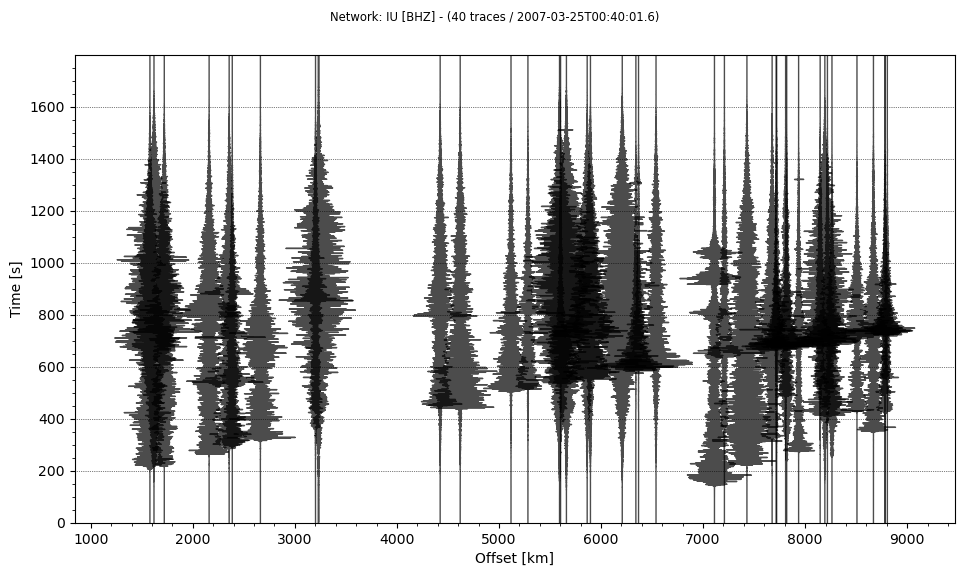

In [64]:
st=stbackup.copy()
st.detrend()
st.taper(5)
st.remove_response(output="VEL")
st.detrend(type='polynomial', order=3)
st.taper(5)
st.filter('highpass',freq=0.5)
st.plot(type='section', scale=3, alpha=0.7); plt.show()

/Users/anewman/opt/anaconda3/envs/rterg/lib/python3.9/site-packages/obspy/core/trace.py:2139: UserWarning: The requested taper is longer than the trace. The taper will be shortened to trace length.
  warnings.warn(msg)


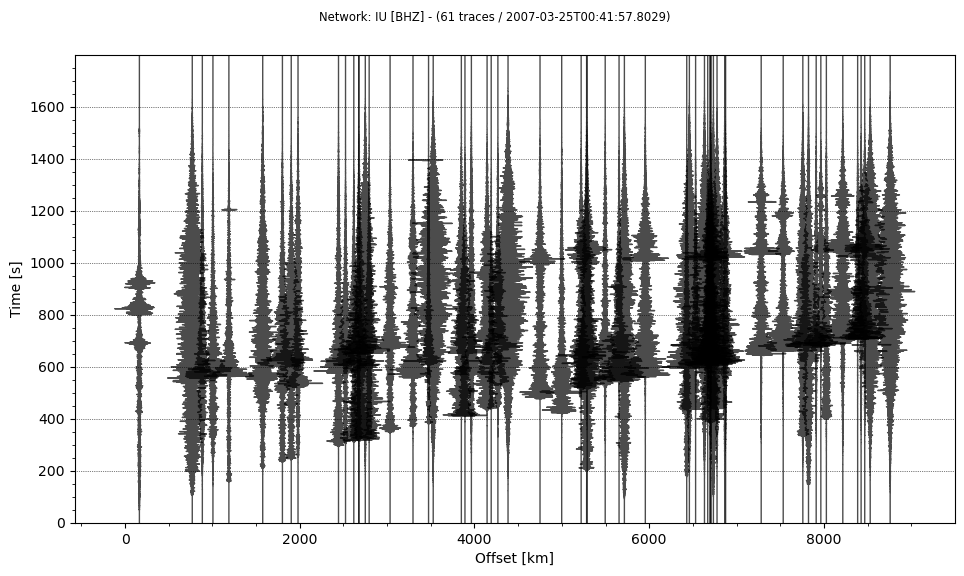

In [63]:
st2=st2backup.copy()
st2.detrend()
st2.taper(5)
st2.remove_response(output="VEL")
st2.detrend(type='polynomial', order=3)
st2.taper(5)
st2.filter('highpass',freq=0.5)
st2.plot(type='section', scale=3, alpha=0.7); plt.show()

In [ ]:
plt.save('')